# Code for generating Figure 2
## "Angular momentum conservation in reverse diffusion"

This self-contained Python notebook contains code for generating the second figure from the [NeurReps](https://www.neurreps.org) 2024 paper **"Dynamical symmetries in the fluctuation-driven regime: an application of Noether's theorem to noisy dynamical systems"**.

In [12]:
# imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch

<center>
<img src="fig_revdiff.png" width="400"/></center>

**Angular momentum conservation in reverse diffusion.** **Left:** depiction of reverse diffusion for a rotationally-symmetric data distribution. **Right:** most likely transition paths given a fixed starting point (black dot) and different angular momentum values (green is lowest, red is highest). Dashed black line is the PF-ODE trajectory.

## 0. Useful functions

In [23]:
# compute least action path / most likely transition path via direct numerical optimization
# see here for inspiration for this code/idea: https://github.com/greydanus/ncf
def get_LAP(z_0, z_f, num_time_pts, t_span, t, L, params, steps=1000, step_size=1e-1, num_prints=8, num_stashes=80):
    t_min, t_max = t_span
    t_ = np.linspace(t_min, t_max, num_time_pts)

    x = z_0[None,:]*(1 - (t[:,None] - t_min)/(t_max - t_min) ) + ( (t[:,None] - t_min)/(t_max - t_min) )*z_f[None,:]
    x.requires_grad = True
     
    print_on = np.linspace(0,int(np.sqrt(steps)),num_prints).astype(np.int32)**2 # print more often early in loop

    for i in range(steps):
        grad_x = torch.autograd.grad(action(x, t, L, params), x)[0]
        grad_x[[0,-1]] *= 0  # fix first and last coordinates by zeroing their grads
        x.data -= grad_x * step_size

        if i in print_on: print('step={:04d}, S={:.4e}'.format(i, action(x, t, L, params).item()))
    return t_, x

# get action given Lagrangian by integrating
def action(x, t, L, params):
    dt = t[1:]-t[:-1]
    xdot = (x[1:] - x[:-1]) / dt[:,None]     # finite difference approx of time derivative
    L_ = L(x[:-1], xdot, t[:-1], params)  
    return torch.sum( L_*dt )

# Lagrangian for reverse diffusion with a ring-shaped data distribution
# polar coordinates used for convenience
def L_revdiff_ring_polar(z, zdot, t, params):
    sig_0, R = params['sig_0'], params['R']

    rdot, thdot = zdot[:,0], zdot[:,1]
    r, th = z[:,0], z[:,1]
    
    q = 1e-3
    arg = (R*r)/(sig_0**2 + t**2 + q)

    I_0 = torch.special.i0(arg); I_1 = torch.special.i1(arg)
    V = t*(((I_1*R/(I_0 + q) - r)/(sig_0**2 + t**2))**2)
    T = (rdot**2 + (r*thdot)**2)/(4*(t+q))

    L = T + V
    return L

## 1. Cartoon depiction of reverse diffusion

Generate left half of Figure 2.

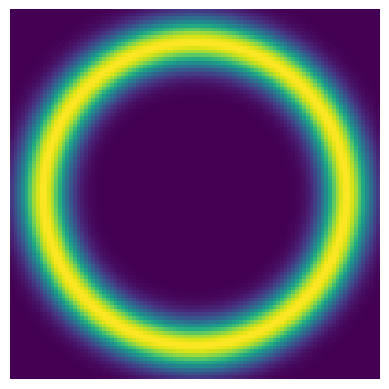

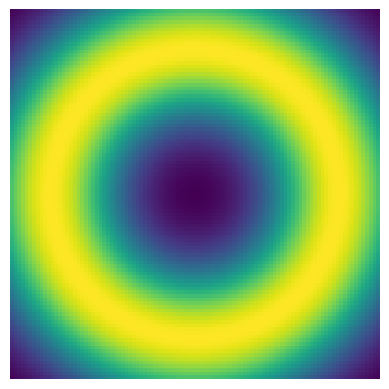

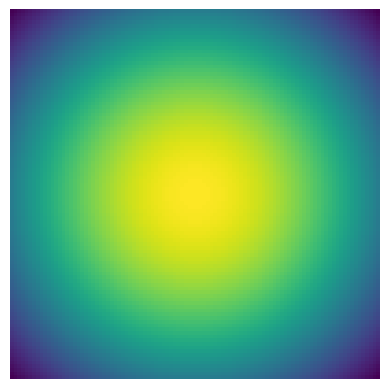

In [27]:
bound = 6
x_min, x_max, num_x = -bound, bound, 100
y_min, y_max, num_y = -bound, bound, 100

x = np.linspace(x_min, x_max, num_x); y = np.linspace(y_min, y_max, num_y)
X, Y = np.meshgrid(x, y, indexing='ij')


####


t__ = 0
r = np.sqrt(X**2 + Y**2)
arg = (R*r)/(sig_0**2 + t__**2)
pdf = norm.pdf(X, scale=np.sqrt(sig_0**2 + t__**2))*norm.pdf(Y, scale=np.sqrt(sig_0**2 + t__**2))*np.exp(-R*R/(2*(sig_0**2 + t__**2)))*iv(0, arg)


fig, ax = plt.subplots()
ax.imshow(pdf.T, origin='lower', alpha=1, extent=[x_min, x_max, y_min, y_max])
ax.set_aspect('equal')

ax.tick_params(axis='both', which='major', labelsize=15); ax.tick_params(axis='both', which='minor', labelsize=15)
ax.axis('off')
plt.savefig('results/revdiff-example_A.png',bbox_inches='tight')
plt.savefig('results/revdiff-example_A.pdf', bbox_inches='tight')
plt.show()


####


t__ = 1.5
r = np.sqrt(X**2 + Y**2)
arg = (R*r)/(sig_0**2 + t__**2)
pdf = norm.pdf(X, scale=np.sqrt(sig_0**2 + t__**2))*norm.pdf(Y, scale=np.sqrt(sig_0**2 + t__**2))*np.exp(-R*R/(2*(sig_0**2 + t__**2)))*iv(0, arg)


fig, ax = plt.subplots()
ax.imshow(pdf.T, origin='lower', alpha=1, extent=[x_min, x_max, y_min, y_max])
ax.set_aspect('equal')

ax.tick_params(axis='both', which='major', labelsize=15); ax.tick_params(axis='both', which='minor', labelsize=15)
ax.axis('off')
plt.savefig('results/revdiff-example_B.png',bbox_inches='tight')
plt.savefig('results/revdiff-example_B.pdf', bbox_inches='tight')
plt.show()

####


t__ = 5
r = np.sqrt(X**2 + Y**2)
arg = (R*r)/(sig_0**2 + t__**2)
pdf = norm.pdf(X, scale=np.sqrt(sig_0**2 + t__**2))*norm.pdf(Y, scale=np.sqrt(sig_0**2 + t__**2))*np.exp(-R*R/(2*(sig_0**2 + t__**2)))*iv(0, arg)


fig, ax = plt.subplots()
ax.imshow(pdf.T, origin='lower', alpha=1, extent=[x_min, x_max, y_min, y_max])
ax.set_aspect('equal')

ax.tick_params(axis='both', which='major', labelsize=15); ax.tick_params(axis='both', which='minor', labelsize=15)
ax.axis('off')
plt.savefig('results/revdiff-example_C.png',bbox_inches='tight')
plt.savefig('results/revdiff-example_C.pdf', bbox_inches='tight')
plt.show()

## 2. Angular momentum and reverse diffusion least action paths

Choose parameters for reverse diffusion model.

In [29]:
num_steps = 50       # number of time steps to consider in numerical path optimization
T = 5                # transition time

pow_start = -0.4
pow_end = 1.5  
t = torch.logspace(pow_start, pow_end, num_steps)     # discretization of time
t_span = [10**pow_start, 10**pow_end]

R = 5             # width of data distribution ring
sig_0 = 0.55      # data distribution noise about ring         
params = {'R':R, 'sig_0':sig_0}

Compute four least action paths, each with different values of angular momentum. (Note: L is not actually computed, but could be in principle given the LAPs. The point here is to notice qualitatively how the semicircular arcs vary depending on the prescribed path endpoint.)

In [31]:
z_0 = torch.tensor([R,np.pi/4]); z_f = torch.tensor([2*R, np.pi/2])
t_a, x_a = get_LAP(z_0, z_f, num_steps, t_span, t, L_revdiff_ring_polar, params, steps=60000, step_size=2e-4)

step=0000, S=8.6046e-01
step=1156, S=8.5403e-01
step=4761, S=8.3969e-01
step=10816, S=8.2123e-01
step=19321, S=8.0083e-01
step=30276, S=7.7973e-01
step=43681, S=7.5870e-01
step=59536, S=7.3809e-01


In [33]:
z_0 = torch.tensor([R,0]); z_f = torch.tensor([2*R, np.pi/2])
t_b, x_b = get_LAP(z_0, z_f, num_steps, t_span, t, L_revdiff_ring_polar, params, steps=60000, step_size=2e-4)

step=0000, S=9.4255e-01
step=1156, S=9.3144e-01
step=4761, S=9.1248e-01
step=10816, S=8.9039e-01
step=19321, S=8.6702e-01
step=30276, S=8.4353e-01
step=43681, S=8.2041e-01
step=59536, S=7.9784e-01


In [35]:
z_0 = torch.tensor([R,-np.pi/4]); z_f = torch.tensor([2*R, np.pi/2])
t_c, x_c = get_LAP(z_0, z_f, num_steps, t_span, t, L_revdiff_ring_polar, params, steps=60000, step_size=2e-4)

step=0000, S=1.0794e+00
step=1156, S=1.0604e+00
step=4761, S=1.0337e+00
step=10816, S=1.0055e+00
step=19321, S=9.7716e-01
step=30276, S=9.4944e-01
step=43681, S=9.2264e-01
step=59536, S=8.9683e-01


In [37]:
z_0 = torch.tensor([R,-np.pi/2]); z_f = torch.tensor([2*R, np.pi/2])
t_d, x_d = get_LAP(z_0, z_f, num_steps, t_span, t, L_revdiff_ring_polar, params, steps=60000, step_size=2e-4)

step=0000, S=1.2709e+00
step=1156, S=1.2410e+00
step=4761, S=1.2032e+00
step=10816, S=1.1663e+00
step=19321, S=1.1307e+00
step=30276, S=1.0967e+00
step=43681, S=1.0642e+00
step=59536, S=1.0329e+00


Convert polar coordinates to Euclidean coordinates.

In [39]:
path_a = x_a.detach().cpu().numpy()
path_b = x_b.detach().cpu().numpy()
path_c = x_c.detach().cpu().numpy()
path_d = x_d.detach().cpu().numpy()


r_a, th_a = path_a.T
xs_a = r_a*np.cos(th_a); ys_a = r_a*np.sin(th_a)

r_b, th_b = path_b.T
xs_b = r_b*np.cos(th_b); ys_b = r_b*np.sin(th_b)

r_c, th_c = path_c.T
xs_c = r_c*np.cos(th_c); ys_c = r_c*np.sin(th_c)

r_d, th_d = path_d.T
xs_d = r_d*np.cos(th_d); ys_d = r_d*np.sin(th_d)

Generate figure (right half of Figure 2).

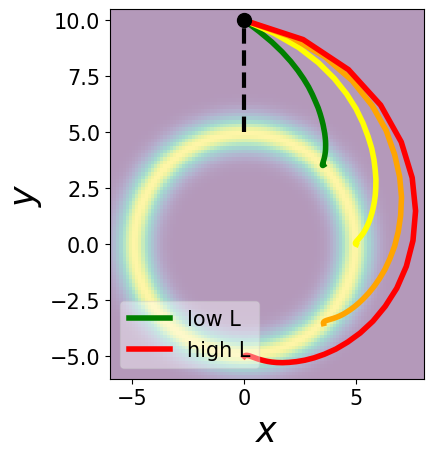

In [55]:
bound = 9
x_min, x_max, num_x = -6, 8, 100
y_min, y_max, num_y = -6, 10.5, 100

x = np.linspace(x_min, x_max, num_x); y = np.linspace(y_min, y_max, num_y)
X, Y = np.meshgrid(x, y, indexing='ij')

# get data distribution to display as heatmap
t__ = 0
r = np.sqrt(X**2 + Y**2)
arg = (R*r)/(sig_0**2 + t__**2)
pdf = norm.pdf(X, scale=np.sqrt(sig_0**2 + t__**2))*norm.pdf(Y, scale=np.sqrt(sig_0**2 + t__**2))*np.exp(-R*R/(2*(sig_0**2 + t__**2)))*iv(0, arg)


################################

label_me = True   # if want x and y axis labels (and legend) shown


fig, ax = plt.subplots()
ax.imshow(pdf.T, origin='lower', alpha=0.4, extent=[x_min, x_max, y_min, y_max])
ax.scatter(0, 2*R, color='black', s=100,zorder=3)
ax.set_aspect('equal')

lw = 4
ax.plot(xs_a, ys_a, linewidth=lw, color='green', label='low L')
ax.plot(xs_b, ys_b, linewidth=lw, color='yellow')
ax.plot(xs_c, ys_c, linewidth=lw, color='orange')
ax.plot(xs_d, ys_d, linewidth=lw, color='red', label='high L')
ax.plot(np.zeros(100), np.linspace(R, 2*R, 100), color='black', linestyle='--', linewidth=lw-1)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

if label_me:
    ax.set_xlabel('$x$', fontsize=25)
    ax.set_ylabel('$y$', fontsize=25)
    ax.legend(fontsize=15, loc='lower left', framealpha=0.4)

plt.savefig('results/revdiff-spiral.png',bbox_inches='tight')
plt.savefig('results/revdiff-spiral.pdf', bbox_inches='tight')
plt.show()